In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

from itertools import chain
import scripts.preprocessing as preprocessing

import tensorflow as tf
from cv2 import cv2

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## Loading Data

In [2]:
# Loading DICOM data
dicom_data = []
image_names = glob('*.dcm')
for img_name in image_names:
    dcm = pydicom.dcmread(img_name)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription, dcm.Rows, dcm.Columns, img_name, dcm.pixel_array]
    dicom_data.append(fields)
dicom_df = pd.DataFrame(dicom_data, columns = ['PatientID','PatientAge','PatientSex','Modality','Finding Labels','Rows','Columns', 'Filename', 'Image'])

In [3]:
## Load NIH data
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')

In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')

## Findings and their correlation

First we'll analyse our data with respect to every finding.
Then we'll target specifically the subset of pneumonia cases among our dataset.

In [5]:
# As in Exploring Population Metadata Exercise, split Finding Labels into one per disease to ease processing
def splitFindings(df_src):
    d = df_src.copy()
    all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
    all_labels = [x for x in all_labels if len(x)>0]
    for c_label in all_labels:
        if len(c_label)>1: # leave out empty labels
            d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    return d, all_labels
split_xray_df, disease_labels = splitFindings(all_xray_df)

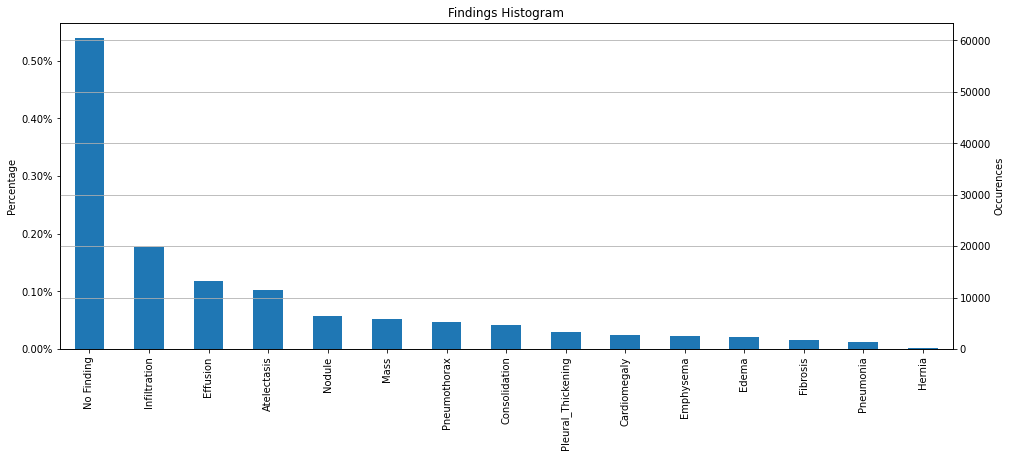

In [6]:
def occurance_rate_histogram(df, ax=None):
    if not ax:
        _, ax = plt.subplots(figsize=(16,6))
    ax = df.mean().sort_values(ascending=False).plot.bar()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.set(ylabel = 'Percentage')
    # ax.grid(True)
    ax2 = ax.twinx()
    ax2 = df.sum().sort_values(ascending=False).plot.bar()
    ax2.set(title='Findings Histogram', ylabel = 'Occurences')
    ax2.grid(True)
    plt.show()

occurance_rate_histogram(split_xray_df[disease_labels])

No finding is necessarily independent of the others, meaning the data is mostly representative No Finding X-Rays.

In [7]:
num_data = len(split_xray_df)
total_no_findings = split_xray_df['No Finding'].sum()
total_findings = num_data - total_no_findings
print(f'In a dataset with {num_data} samples, no findings are represented in {total_no_findings} cases, while diseases and conditions are found in {total_findings} cases.')

In a dataset with 112120 samples, no findings are represented in 60361.0 cases, while diseases and conditions are found in 51759.0 cases.


## Distribuition of Pneumonia

We'll address how Pneumonia represented in our data and distributed across the age and gender.

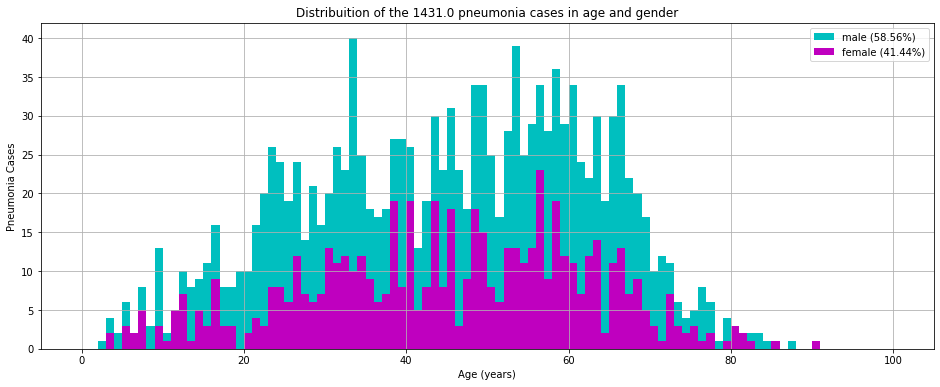

In [8]:
total_cases = split_xray_df.Pneumonia.sum()
male_ratio = split_xray_df[split_xray_df['Patient Gender'] == 'M']['Pneumonia'].sum() / total_cases
female_ratio = split_xray_df[split_xray_df['Patient Gender'] == 'F']['Pneumonia'].sum() / total_cases
_, ax = plt.subplots(figsize=(16,6))
# emulate a stacked plot using total and one of the classes
ax.hist(split_xray_df[(split_xray_df.Pneumonia==1)]['Patient Age'], range=[0, 100], bins=100, color=['c'], stacked=True)
ax.hist(split_xray_df[(split_xray_df.Pneumonia==1) & (split_xray_df['Patient Gender'] == 'F')]['Patient Age'], range=[0, 100], bins=100, color=['m'], stacked=True)
ax.legend([f'male ({male_ratio*100:.2f}%)', f'female ({female_ratio*100:.2f}%)'], prop={'size': 10})
ax.grid(True)
ax.set(title=f'Distribuition of the {total_cases} pneumonia cases in age and gender', xlabel = 'Age (years)', ylabel = 'Pneumonia Cases')
plt.show()

It seems Pneumonia is well distribuited across all ages. 

When compared to the entire dataset, pneumonia only account for little subset of it

In [9]:
num_data = len(split_xray_df)
total_non_pneumonia = num_data - total_cases
print(f'The {total_cases} cases of pneumonia only accounts for {100*total_cases/num_data:.2f}% of the data, as there are still {total_non_pneumonia} images where pneumonia is not found')

The 1431.0 cases of pneumonia only accounts for 1.28% of the data, as there are still 110689.0 images where pneumonia is not found


So it will be specially important to explore data augmentation strategies to take the most advantage of the few data we dispose.

Now let's address if there's any co-occurrence of pneumonia reported in the findings.

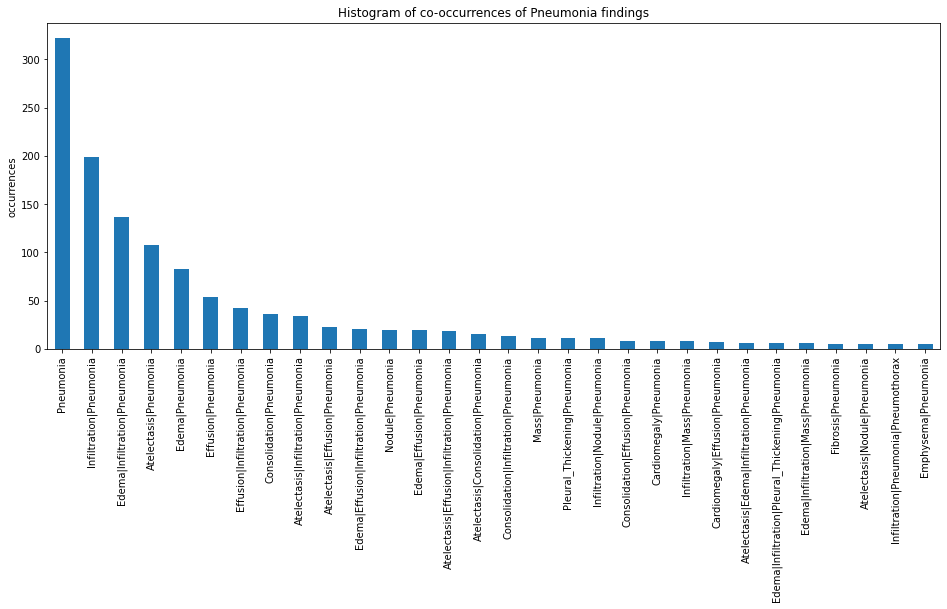

In [10]:
plt.figure(figsize=(16,6))
ax = split_xray_df[split_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
ax.set(title='Histogram of co-occurrences of Pneumonia findings', ylabel='occurrences')
plt.show()

So Pneumonia is often reported alongside some other findings as Infiltration, Edema, Alectasis and Effusion.

(1431, 4)


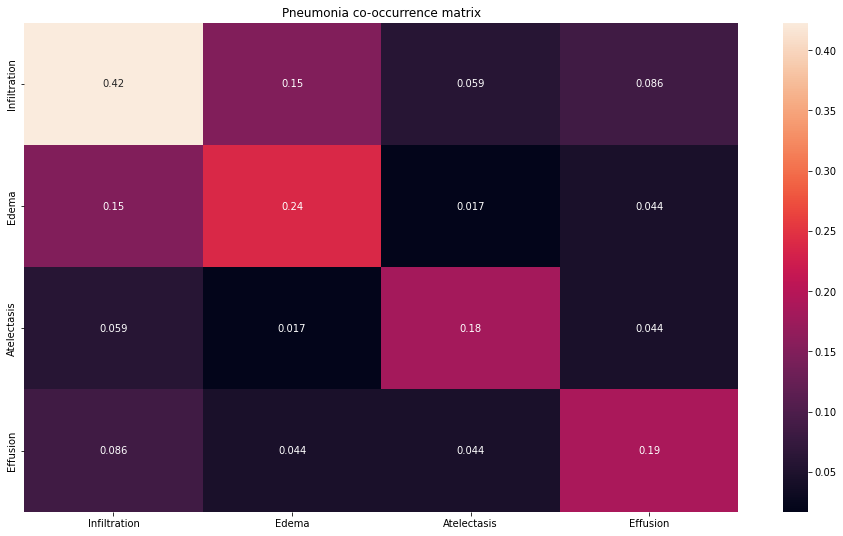

In [11]:
labels = ['Infiltration', 'Edema', 'Atelectasis', 'Effusion']
plt.figure(figsize=(16,9))
array = split_xray_df[split_xray_df.Pneumonia==1][labels].to_numpy() 
print(array.shape)
co_matrix = array.T.dot(array) / array.shape[0]
ax = sns.heatmap(co_matrix, annot = True, yticklabels=labels, xticklabels=labels)
ax.set(title='Pneumonia co-occurrence matrix')
plt.show()

So in 42% of pneumonia chest x-rays infiltration is also reported in contrast with 24% of edema, 18% of atelectasis and 19% of effusion.

The highest crossed co-occurrence is of infiltration and edema alongside with pneumonia.

## Quick analysis of the images

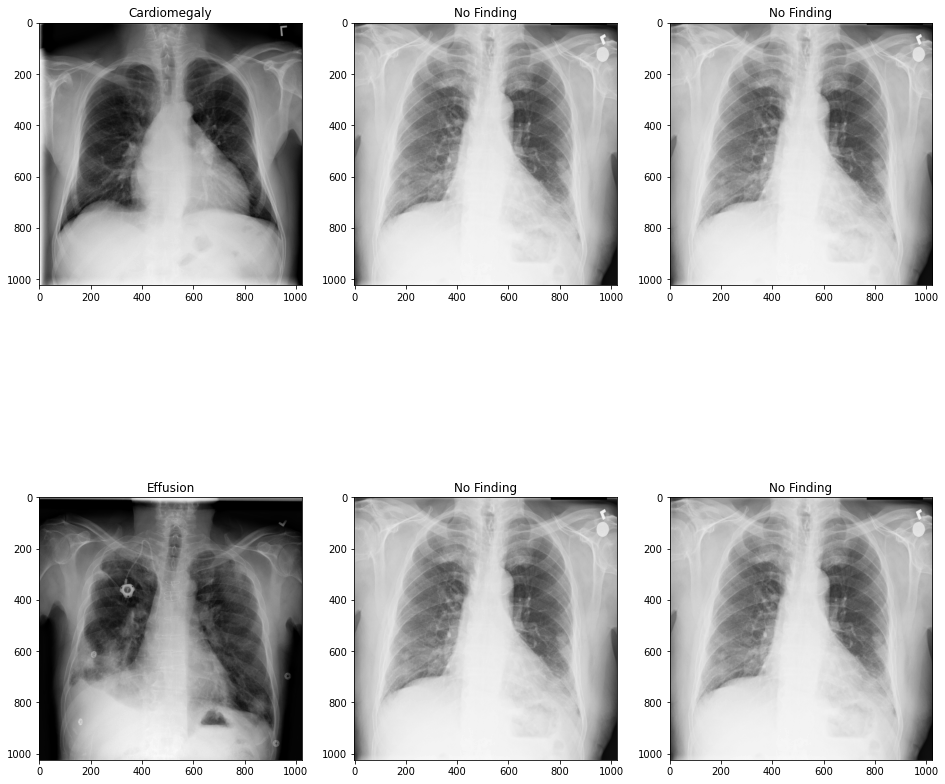

In [12]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = dicom_df.Image
ind=0
for img, ax in zip(imgs, m_axs):
    ax.imshow(img,cmap='gray')
    ax.set_title(dicom_df.iloc[ind]['Finding Labels'])
    ind=ind+1

In fact, although we dispose of six dicom image files, all the four no finding images are identical, all corresponding to patient ID 2.

In [13]:
diff = np.sum(np.sum(np.abs(np.diff(dicom_df[dicom_df['PatientID'].astype(int) == 2].Image))))
print(f'Cumulative sum of absolute pixel difference between pixels in images of patient 2 is {diff}')

Cumulative sum of absolute pixel difference between pixels in images of patient 2 is 0


From now on only three images will then be considered for analysis.

In [14]:
dicom_df = dicom_df.drop_duplicates(subset=['PatientID'])
dicom_df

,PatientID,PatientAge,PatientSex,Modality,Finding Labels,Rows,Columns,Filename,Image
0,1,58,M,DX,Cardiomegaly,1024,1024,test2.dcm,"[[202, 199, 195, 193, 195, 194, 193, 192, 184,..."
1,2,81,M,DX,No Finding,1024,1024,test6.dcm,"[[199, 175, 152, 133, 124, 118, 113, 111, 110,..."
3,61,77,M,DX,Effusion,1024,1024,test3.dcm,"[[142, 142, 143, 141, 143, 140, 140, 136, 137,..."


### Preprocessing Choices

Histogram comparison between images with three different pre-processing steps:

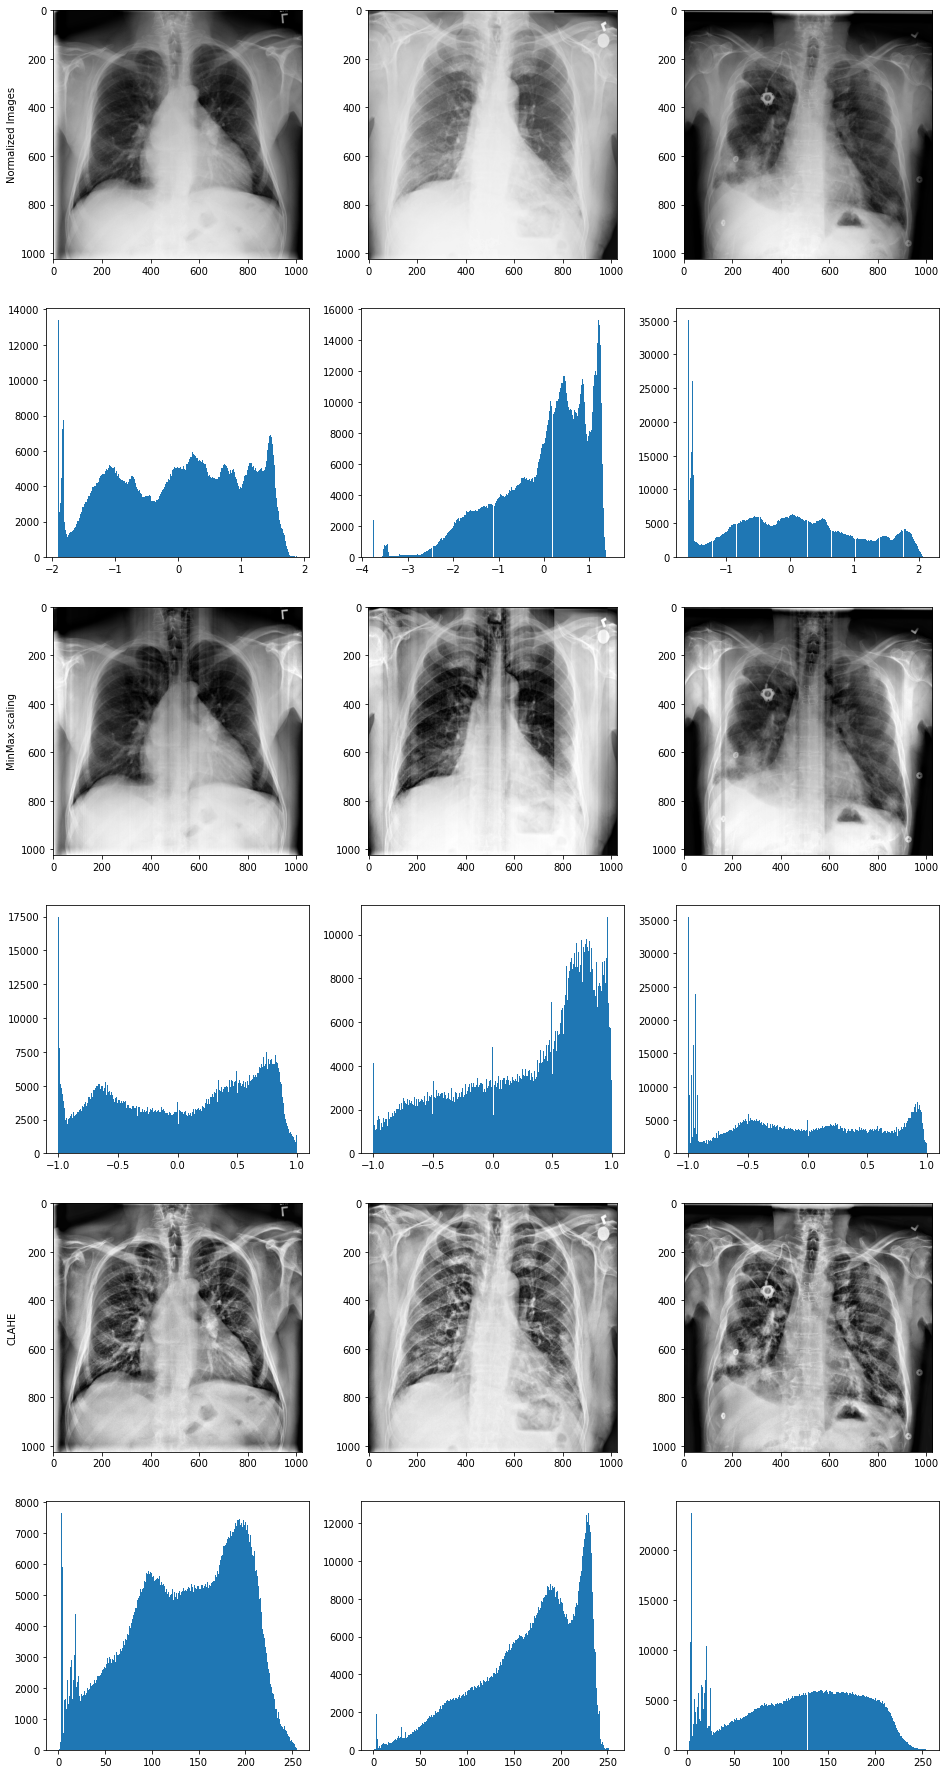

In [15]:
fig, m_axs = plt.subplots(6,3, figsize = (16, 32))
normalized_imgs = dicom_df.Image.apply(preprocessing.normalize_image)
scaled_imgs = dicom_df.Image.apply(preprocessing.min_max_scaling)
clahe_imgs = dicom_df.Image.apply(preprocessing.clahe_scaling)
for ind in range(3):
    m_axs[0, ind].imshow(normalized_imgs.iloc[ind],cmap='gray')
    ax.set_title(dicom_df.iloc[ind]['Finding Labels'])
m_axs[0, 0].set_ylabel(f'Normalized Images')
for ind in range(3):
    m_axs[1, ind].hist(normalized_imgs.iloc[ind].ravel(), bins = 256)
for ind in range(3):
    m_axs[2, ind].imshow(scaled_imgs.iloc[ind],cmap='gray')
m_axs[2, 0].set_ylabel(f'MinMax scaling')
for ind in range(3):
    m_axs[3, ind].hist(scaled_imgs.iloc[ind].ravel(), bins = 256)
for ind in range(3):
    m_axs[4, ind].imshow(clahe_imgs.iloc[ind],cmap='gray')
m_axs[4, 0].set_ylabel(f'CLAHE')
for ind in range(3):
    m_axs[5, ind].hist(clahe_imgs.iloc[ind].ravel(), bins = 256)
plt.show()

In [16]:
INPUT_SHAPE = (224, 224, 3)


inputs = tf.keras.Input(shape=INPUT_SHAPE),
vgg_preprocessing = tf.keras.models.Sequential(tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,
                                             input_shape=INPUT_SHAPE), name='vgg-preprocessing')

x = vgg_preprocessing(inputs)

preprocessing_model = tf.keras.Model(inputs, x)

2021-11-10 17:16:24.437535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:16:24.442208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:16:24.442443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 17:16:24.442965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
def predict_peak(model, src_img, df, clipping=False):
    output = model.predict(src_img)
    split_df, _ = splitFindings(df)
    fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
    for ind in range(imgs.shape[0]):
        image = output[ind]
        if clipping:
            image = image - image.min()
            image /= image.max()
        m_axs[0, ind].imshow(image)
        ax.set_title(df.iloc[ind]['Finding Labels'])
        m_axs[1, ind].hist(output[ind].ravel(), bins = 256)

def series_to_array(series):
    return np.stack([arr for arr in series.to_numpy()])

### Only vgg_preprocessing

2021-11-10 17:16:24.806972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


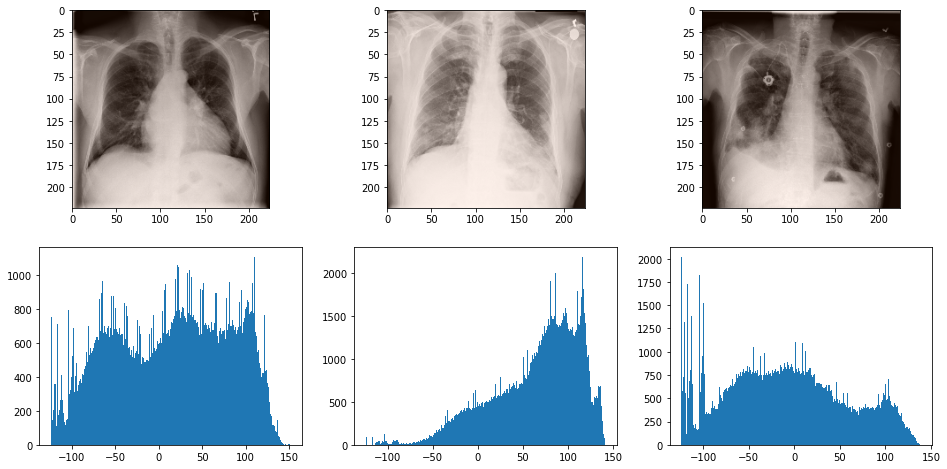

In [18]:
imgs = dicom_df.Image.copy()
imgs = imgs.apply(cv2.cvtColor, args=[cv2.COLOR_GRAY2RGB])
imgs = imgs.apply(cv2.resize, args=[(224, 224)])
imgs = series_to_array(imgs)

# imgs = np.stack([cv2.resize(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (224, 224)) for img in dicom_df.Image.to_numpy()])
predict_peak(preprocessing_model, imgs, dicom_df, clipping=True)

### Normalization +  vgg_preprocessing

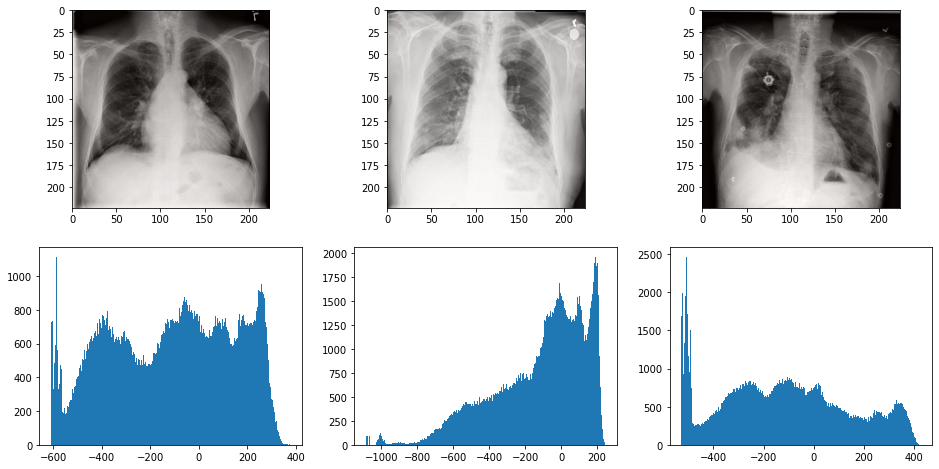

In [19]:
normalized_imgs = dicom_df.Image.apply(preprocessing.normalize_image)
normalized_imgs = normalized_imgs.apply(cv2.resize, args=[(224, 224)])
normalized_imgs = normalized_imgs.apply(np.reshape, args=[(224, 224, 1)])
normalized_imgs = normalized_imgs.apply(np.broadcast_to, args=[(224, 224, 3)])
normalized_imgs = series_to_array(normalized_imgs) * 255
predict_peak(preprocessing_model, normalized_imgs, dicom_df, clipping=True)

Normalization is not adequate as the mean value compared to only doing the preprocessing changes significantly, as both the mean of imagenet is subtracted and each image mean.

### Min Max scalling +  vgg_preprocessing

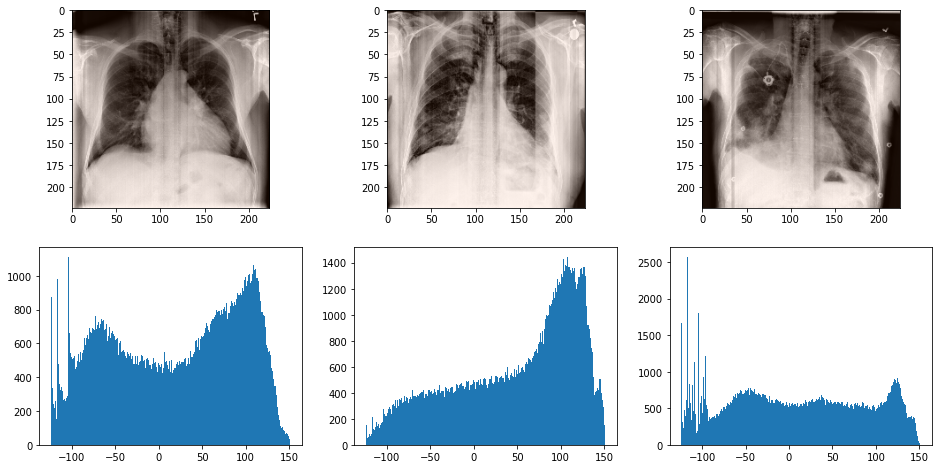

In [20]:
minmax_imgs = dicom_df.Image.apply(preprocessing.min_max_scaling, args=[(0, 0xFF)])
minmax_imgs = minmax_imgs.apply(cv2.resize, args=[(224, 224)])
minmax_imgs = minmax_imgs.apply(np.reshape, args=[(224, 224, 1)])
minmax_imgs = minmax_imgs.apply(np.broadcast_to, args=[(224, 224, 3)])
minmax_imgs = series_to_array(minmax_imgs)
predict_peak(preprocessing_model, minmax_imgs, dicom_df, clipping=True)

### CLAHE scalling +  vgg_preprocessing

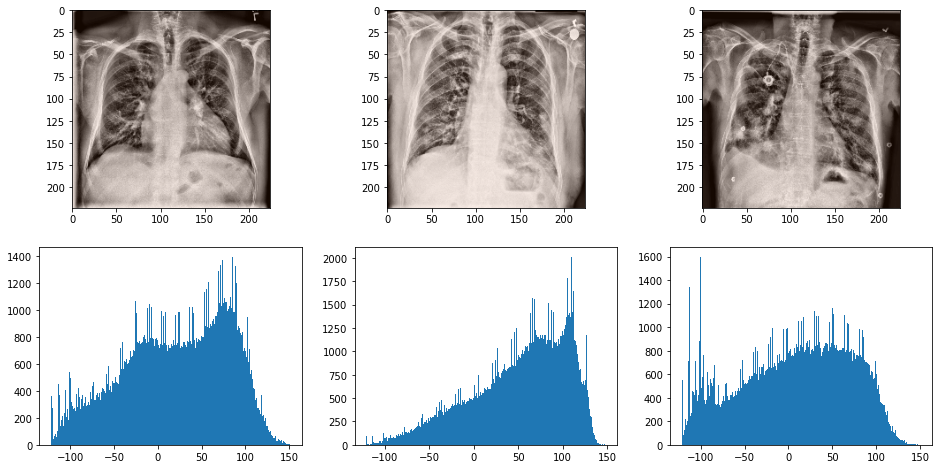

In [21]:
clahe_imgs = dicom_df.Image.apply(preprocessing.clahe_scaling)
clahe_imgs = clahe_imgs.apply(cv2.resize, args=[(224, 224)])
clahe_imgs = clahe_imgs.apply(np.reshape, args=[(224, 224, 1)])
clahe_imgs = clahe_imgs.apply(np.broadcast_to, args=[(224, 224, 3)])
clahe_imgs = series_to_array(clahe_imgs)
predict_peak(preprocessing_model, clahe_imgs, dicom_df, clipping=True)

Both CLAHE and Min-Max scalling can be used and seem to preserve the input requirements of the VGG16 model.


From this preliminary data analysis, the histograms of No Findings X-Rays seems to differ significantly from the ones presenting effusion and Cardiomegaly with the normalization and min_max scalling approach.
CLAHE normalization on another hand is able to enhance contrast of the lungs and could be used to better identify the opacity effect seen both in effusion and cardiomegaly.
This is not enough, however to conclude much, since only three images were analysed and one of them presents artificial implants.